# Testing compatability of `ddls` with `rllib`

In [32]:
%load_ext autoreload
from ddls.environments.job_placing.job_placing_all_nodes_environment import JobPlacingAllNodesEnvironment
from ddls.devices.processors.gpus.A100 import A100
from ddls.distributions.uniform import Uniform
from ddls.dgl_tests.rllib_model_test import GNNPolicy
from ddls.plotting.plotting import plot_line

import ray
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print
ray.shutdown()
ray.init()

from ray.rllib.models import ModelCatalog
from ray.rllib.agents import ppo


from omegaconf import OmegaConf
from IPython.display import display
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Register the custom environment with `ray`

In [33]:
register_env('job_placing_all_nodes_environment', lambda env_config: JobPlacingAllNodesEnvironment(**env_config))

### Register the custom model with `rllib`

In [34]:
ModelCatalog.register_custom_model('my_model', GNNPolicy)

### Load `rllib` config

In [35]:
# # load config
# config = OmegaConf.load('configs/ddls_job_placing_rllib.yaml')
# print(OmegaConf.to_yaml(config))

# # convert config to dict so that is comparible with rllib
# config = OmegaConf.to_container(config, resolve=False)
# print(config)

In [41]:
%autoreload
node_config = {'type_1':
                  {
                      'num_nodes': 16,
                      'workers_config': 
                          [
                              {
                               'num_workers': 4,
#                                'worker': A100
                               'worker': 'ddls.devices.processors.gpus.A100.A100'
                              }
                          ]
                  }
              }

topology_config = {'type':
                      'torus',
                   'kwargs':
                      {
                          'x_dims': 4,
                          'y_dims': 4
                      }
                  }

jobs_config = {'path_to_files': '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid',
               'job_interarrival_time_dist': Uniform(min_val=1, max_val=1000),
               'max_files': 1,
               'job_sampling_mode': 'remove'}


env_config = {'node_config': node_config,
              'topology_config': topology_config,
              'jobs_config': jobs_config,
              'reward_function': 'mean_job_completion_time'}


# model_config = {
#         'in_features_node':19,
#         'in_features_edge':11,
#         'out_features_msg':8,
#         'out_features_hidden':16,
#         'out_features':4,
#         'in_features_graph':4,
#         'out_features_graph':4,
#         'num_layers':1,
#         'aggregator_type':'mean'
#     }



rllib_config = {
    
    'seed': 0,
    
    'env': 'job_placing_all_nodes_environment',
    
    'env_config': env_config,
    
    'batch_mode': 'complete_episodes',
    'train_batch_size': 128,
    'sgd_minibatch_size': 128,
    
#     'model':{
#             'fcnet_hiddens':[8],
#             'fcnet_activation':'relu',
#             'custom_model':'my_model',
#             'custom_model_config':model_config
#         },

        
    
}

# print(OmegaConf.to_yaml(rllib_config))
print(rllib_config)

{'seed': 0, 'env': 'job_placing_all_nodes_environment', 'env_config': {'node_config': {'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': 'ddls.devices.processors.gpus.A100.A100'}]}}, 'topology_config': {'type': 'torus', 'kwargs': {'x_dims': 4, 'y_dims': 4}}, 'jobs_config': {'path_to_files': '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid', 'job_interarrival_time_dist': <ddls.distributions.uniform.Uniform object at 0x7fa7f82203a0>, 'max_files': 1, 'job_sampling_mode': 'remove'}, 'reward_function': 'mean_job_completion_time'}, 'batch_mode': 'complete_episodes', 'train_batch_size': 128, 'sgd_minibatch_size': 128}


### Initialise an `rllib` epoch loop

In [44]:
%autoreload

# load default PPO config and update with custom config params
ppo_config = ppo.DEFAULT_CONFIG.copy()
ppo_config.update(rllib_config)
# print(f'Config:\n{ppo_config}')

for key, val in ppo_config.items():
    print(f'\n{key} {val}')

# initialise rllib trainer
epoch_loop = ppo.PPOTrainer(config=ppo_config)
print('\nInitialised trainer.')

2022-04-14 12:51:49,068	WARNING ppo.py:223 -- `train_batch_size` (128) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 64.



num_workers 2

num_envs_per_worker 1

create_env_on_driver False

rollout_fragment_length 200

batch_mode complete_episodes

gamma 0.99

lr 5e-05

train_batch_size 128

model {'_use_default_native_models': False, '_disable_preprocessor_api': False, '_disable_action_flattening': False, 'fcnet_hiddens': [256, 256], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_

2022-04-14 12:51:58,883	WARNING util.py:55 -- Install gputil for GPU system monitoring.



Initialised trainer.


### Run `rllib` on the `ddls` environment

In [43]:
%autoreload

agent_name = 'PPO'
num_epochs = 50
rl_training_stats = defaultdict(lambda: [])
for epoch in range(num_epochs):
    print(f'\n------- Epoch {epoch+1} of {num_epochs} -------')
    result = epoch_loop.train()
    
    # print epoch data
    print(pretty_print(result))
    
    # save epoch data
    for key, val in result['hist_stats'].items():
        rl_training_stats[key].extend(val)
    for _ in range(len(val)):
        rl_training_stats['seed'].append(result['config']['seed'])
        rl_training_stats['agent'].append(agent_name)
        rl_training_stats['epoch'].append(epoch)
        
# display(pd.DataFrame(rl_training_stats))


------- Epoch 1 of 50 -------
agent_timesteps_total: 128
custom_metrics: {}
date: 2022-04-14_12-44-37
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -3.801335095674546
episode_reward_mean: -3.851022019014805
episode_reward_min: -4.313972618860607
episodes_this_iter: 128
episodes_total: 128
experiment_id: 2d29b387607c4826bce611f8c120a33b
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.20000000298023224
        cur_lr: 4.999999873689376e-05
        entropy: 4.104190349578857
        entropy_coeff: 0.0
        kl: 0.0583382248878479
        model: {}
        policy_loss: -0.14000539481639862
        total_loss: 11.510553359985352
        vf_explained_var: -8.940696716308594e-08
        vf_loss: 11.638890266418457
  num_agent_steps_sampled: 128
  num_agent_steps_trained: 128
  num_steps_sampled: 128
  num_steps_trained: 128
  num_steps_trained_this_iter: 128
iterations_since_

KeyboardInterrupt: 

Plotting metric episode_reward


<Figure size 1920x1440 with 0 Axes>

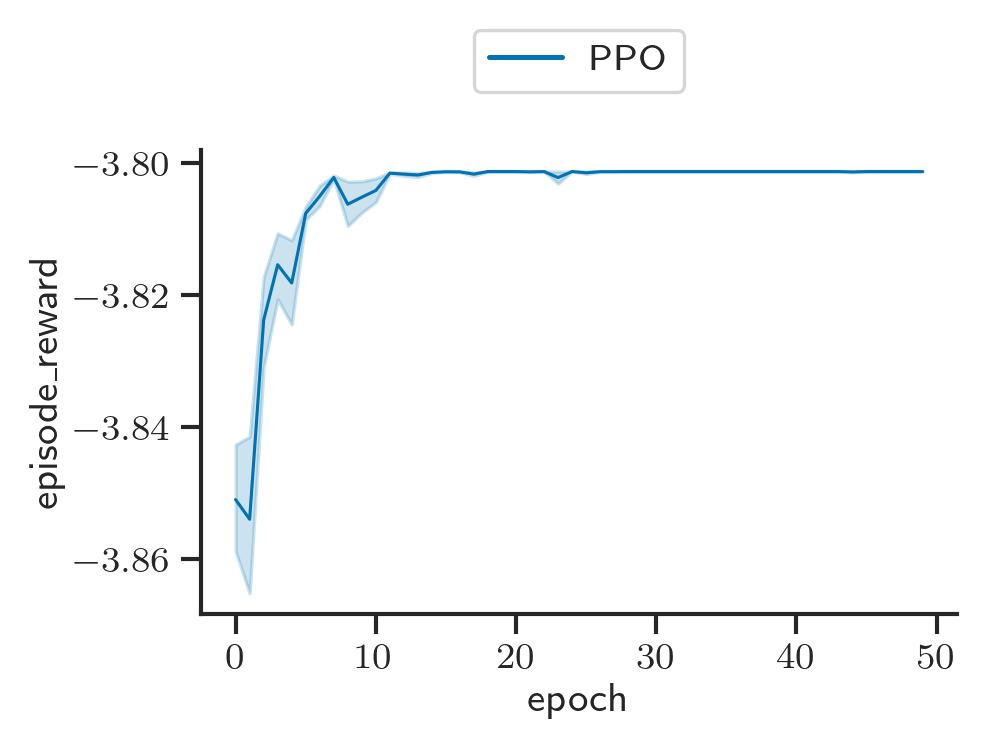

Plotting metric episode_lengths


<Figure size 1920x1440 with 0 Axes>

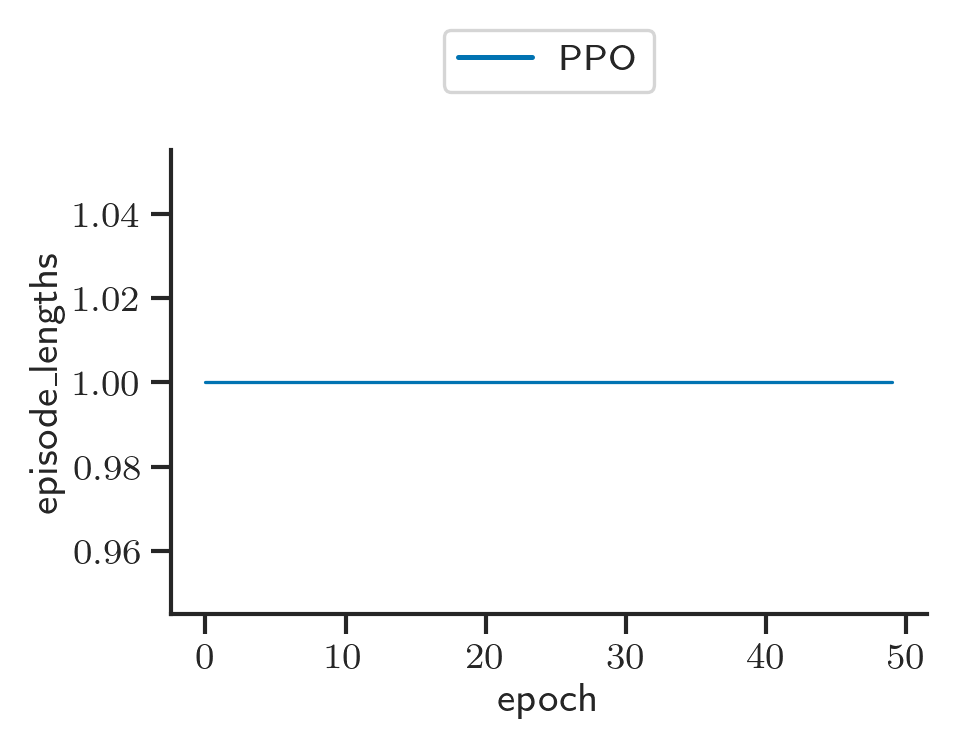

In [31]:
x = 'epoch'
scaling_factor = 1
metrics_to_plot = {'episode_reward', 'episode_lengths'}

for metric in metrics_to_plot:
    print(f'Plotting metric {metric}')
    fig = plt.figure()
    fig = plot_line(pd.DataFrame(rl_training_stats), 
                    x=x, 
                    y=metric, 
                    hue='agent', 
                    xlabel=x, 
                    ylabel=metric, 
                    err_style='band', # 'band' 'bars'
                    ci=68, # 95 68
                    scaling_factor=scaling_factor,
                    show_fig=False)
#     plt.axhline(y=np.mean(random_baseline_stats[metric]), linestyle='--', color='#a84a32', label='Random')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)
    plt.show()